In [1]:
# %matplotlib widget
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
np.random.seed(42)

In [2]:
# User selection
K = 7
a, b = 0.1, 2
N_train = 80
N_test = 20
var = 0.5

In [3]:
theta_true = np.ones(K)
X_train = np.linspace(a, b, N_train)
X_test = np.random.uniform(a, b, N_test)
print("X_train shape :{}, X_test shape :{}".format(X_train.shape, X_test.shape))

X_train shape :(80,), X_test shape :(20,)


In [4]:
def phi_func(x, k):
    return np.power(x, np.arange(0, k))

def get_y_from_x(x, k, theta):
    if x.shape[0] > 2:
        return np.array([np.random.poisson(phi_func(x_i, k) @ theta) for x_i in x])
    else:
        return np.random.poisson(phi_func(x, k) @ theta)

In [5]:
Y_train = get_y_from_x(X_train, K, theta_true)
Y_test = get_y_from_x(X_test, K, theta_true)

print("Y_train shape :{}, Y_test shape :{}".format(Y_train.shape, Y_test.shape))

Y_train shape :(80,), Y_test shape :(20,)


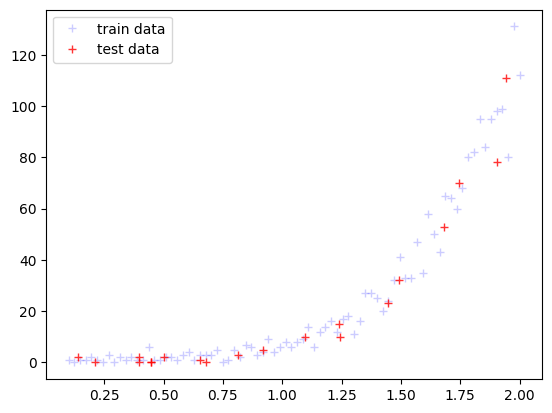

In [6]:
plt.plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
plt.plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
plt.legend()
plt.show()

In [7]:
def generalized_vandermonde_matrix(func_list, X):
    K = len(func_list)
    N = len(X)
    matrix = np.zeros((N, K))
    for i, func in enumerate(func_list):
        matrix[:, i] = func(x=X)
    return matrix

def phi(j, x):
    return np.power(x, j)

def get_normal_vandermonde(K, X):
    vander = generalized_vandermonde_matrix(
        func_list=[partial(phi, j=j) for j in range(K)],
        X=X
    )
    return vander

In [8]:
def MLE_normal_equations(vander, Y):
    return np.linalg.inv(vander.T @ vander) @ vander.T @ Y

def loss(vander, Y, theta):
    N = len(Y)
    tmp = (vander @ theta) - Y
    return (tmp.T @ tmp)/N

In [9]:
def plot_results(k_range, SOL_func):

    _, axs = plt.subplots(1, 3, figsize=(15,3))

    axs = axs.flatten()

    x_plot = np.linspace(a, b, N_train*10)

    train_accuracy = []
    test_accuracy = []

    for k in k_range:
        vander_train = get_normal_vandermonde(k, X_train)
        theta_MLE = SOL_func(vander = vander_train, Y = Y_train)
        train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

        vander_test = get_normal_vandermonde(k, X_test)
        test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

        axs[2].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(k), alpha=0.7)


    axs[0].plot(k_range, train_accuracy, marker=".", label = "train")
    axs[0].plot(k_range, test_accuracy, marker=".", label = "test")
    axs[0].set_title("Loss")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("k")
    axs[0].legend()

    axs[1].plot(k_range, train_accuracy, marker=".", label = "train")
    axs[1].plot(k_range, test_accuracy, marker=".", label = "test")
    axs[1].legend()
    axs[1].set_title("Loss, y in log scale")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("k")
    axs[1].set_yscale("log")

    axs[2].vlines([a, b], axs[2].get_ylim()[0], axs[2].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
    axs[2].plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
    axs[2].plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
    axs[2].set_title("Regressors")
    axs[2].set_ylabel("y")
    axs[2].set_xlabel("x")
    axs[2].legend()

    plt.show()

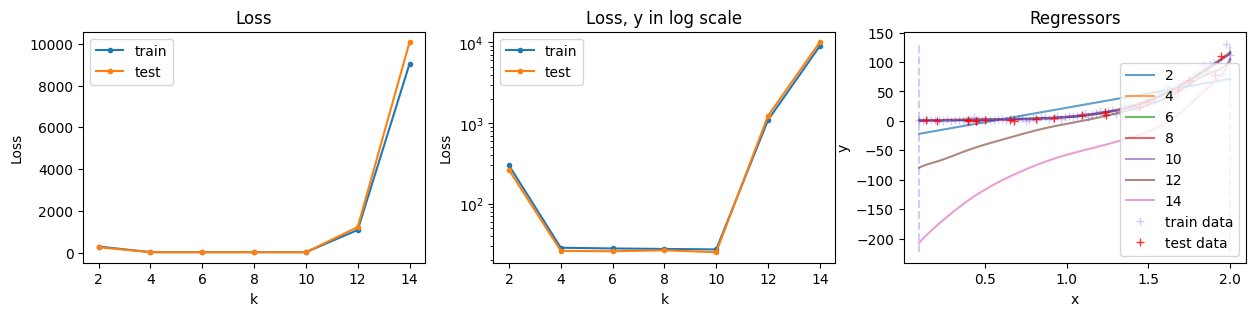

In [10]:
plot_results(range(2, 15, 2), MLE_normal_equations)

As in the case of a model + gaussian noise, for a poisson distribution a linear regressor diverges for high values of K

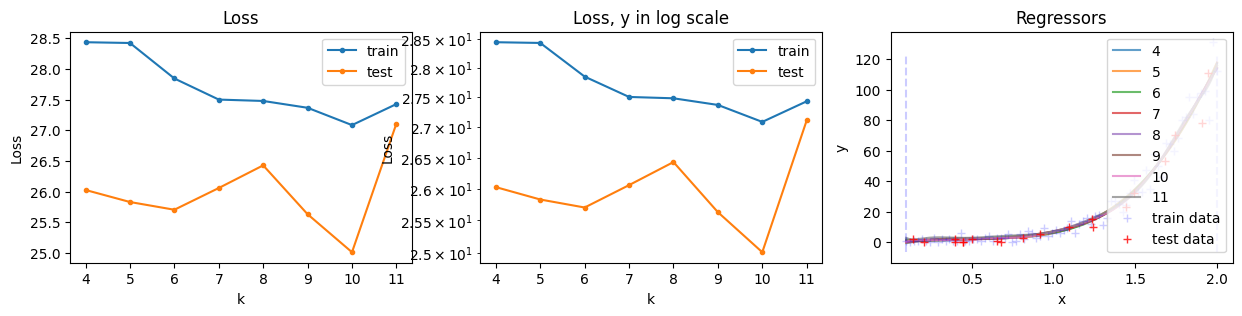

In [11]:
plot_results(range(4, 12), MLE_normal_equations)


And, as before, for values higher than 7/8 we can see some overfitting, deducing that the right model should be around that value, that is correct.

In [12]:
def MAP_normal_equations(vander, lmbd, Y):
    return np.linalg.inv(vander.T @ vander - lmbd * np.eye(vander.shape[1])) @ vander.T @ Y

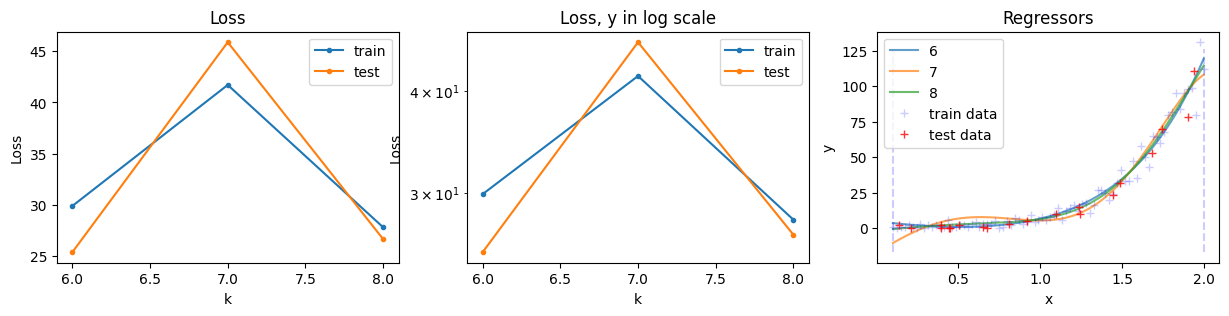

In [13]:
lmbd = 1e-1
plot_results(range(6, 9), partial(MAP_normal_equations, lmbd=lmbd))

In [14]:
def plot_results_varying_lmbd(k, SOL_func, log_scale=False):
    
    _, axs = plt.subplots(1, 2, figsize=(15,3))
    axs = axs.flatten()

    x_plot = np.linspace(a, b, N_train*10)

    train_accuracy = []
    test_accuracy = []

    for lmbd in (lmbd_range := [0, 1e-3, 1e-2, 1e-1, 1]):
        vander_train = get_normal_vandermonde(k, X_train)
        theta_MLE = SOL_func(vander = vander_train, Y = Y_train, lmbd=lmbd)
        train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

        vander_test = get_normal_vandermonde(k, X_test)
        test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

        axs[1].plot(x_plot, get_normal_vandermonde(k, x_plot) @ theta_MLE, label="{}".format(lmbd), alpha=0.7)

    axs[0].plot([1e-4]+lmbd_range[1:], train_accuracy, marker=".", label = "train")
    axs[0].plot([1e-4]+lmbd_range[1:], test_accuracy, marker=".", label = "test")
    axs[0].set_title("Loss")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("lambda")
    axs[0].set_xscale("log")
    if log_scale:
        axs[0].set_yscale("log")
    axs[0].set_xticks([1e-4]+lmbd_range[1:], ["MLE"]+[str(x) for x in lmbd_range[1:]])
    axs[0].legend()

    axs[1].vlines([a, b], axs[1].get_ylim()[0], axs[1].get_ylim()[1], colors="b", linestyles="dashed", alpha=0.2)
    axs[1].plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
    axs[1].plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
    axs[1].set_title("Regressors varying lambda, k = {}".format(k))
    axs[1].set_ylabel("y")
    axs[1].set_xlabel("x")
    axs[1].legend()

    plt.show()

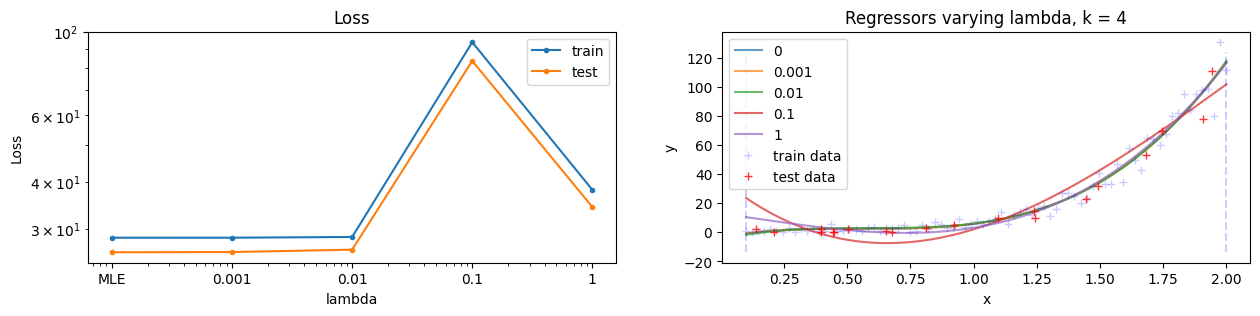

In [15]:
plot_results_varying_lmbd(4, MAP_normal_equations, True)

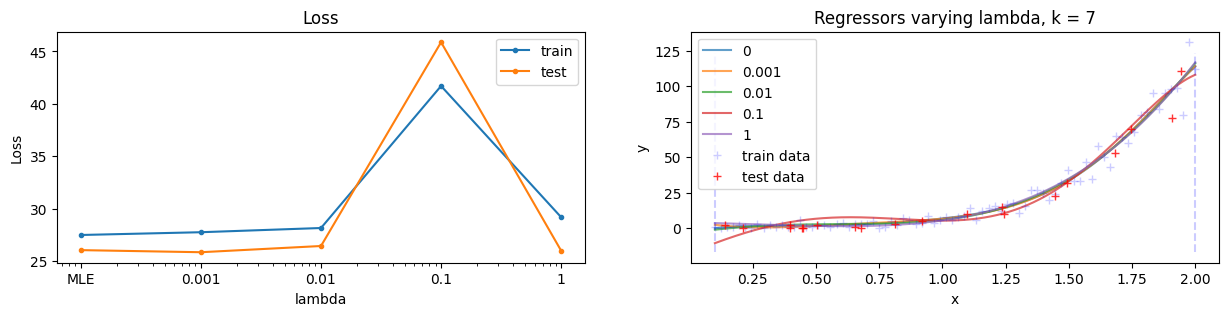

In [16]:
plot_results_varying_lmbd(7, MAP_normal_equations)

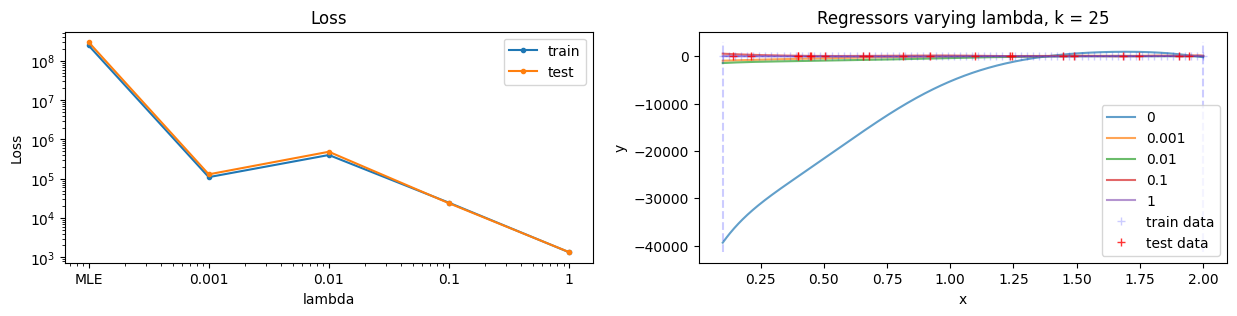

In [17]:
plot_results_varying_lmbd(25, MAP_normal_equations, True)

The addition of a regularizator decreases considerably the overfitting or diverging effects on high capacity models, as seen in the last case.

In [18]:
def param_error(k, lmbd, theta_true):
    vander_train = get_normal_vandermonde(k, X_train)
    theta_MLE = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=lmbd)
    
    resized_th_true = np.pad(theta_true, (0, k-len(theta_true)))

    return np.linalg.norm(resized_th_true - theta_MLE) / np.linalg.norm(resized_th_true)

In [19]:
def plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, ax, title="", rotation=40):

    X_2dplot, Y_2dplot = np.meshgrid(k_vals, lmbd_ticks)

    Z_2dplot = np.zeros((len(lmbd_vals), len(k_vals)))

    for i, k in enumerate(k_vals):
        for j, lmbd in enumerate(lmbd_vals):
            Z_2dplot[j, i] = param_error(k, lmbd, theta_true)

    surf = ax.plot_surface(X_2dplot, Y_2dplot, Z_2dplot, linewidth=0.5, cmap=cm.coolwarm, antialiased=False)
    ax.set_title(title)

    ax.set_xlabel("k")

    ax.set_ylabel("lambda (log scale)")
    ax.set_yticks(lmbd_ticks)
    ax.set_yticklabels(lmbd_labels)

    ax.set_zlabel("Relative error on theta")
    ax.set_zscale("log")
    ax.view_init(20, rotation)

    ax.invert_xaxis()

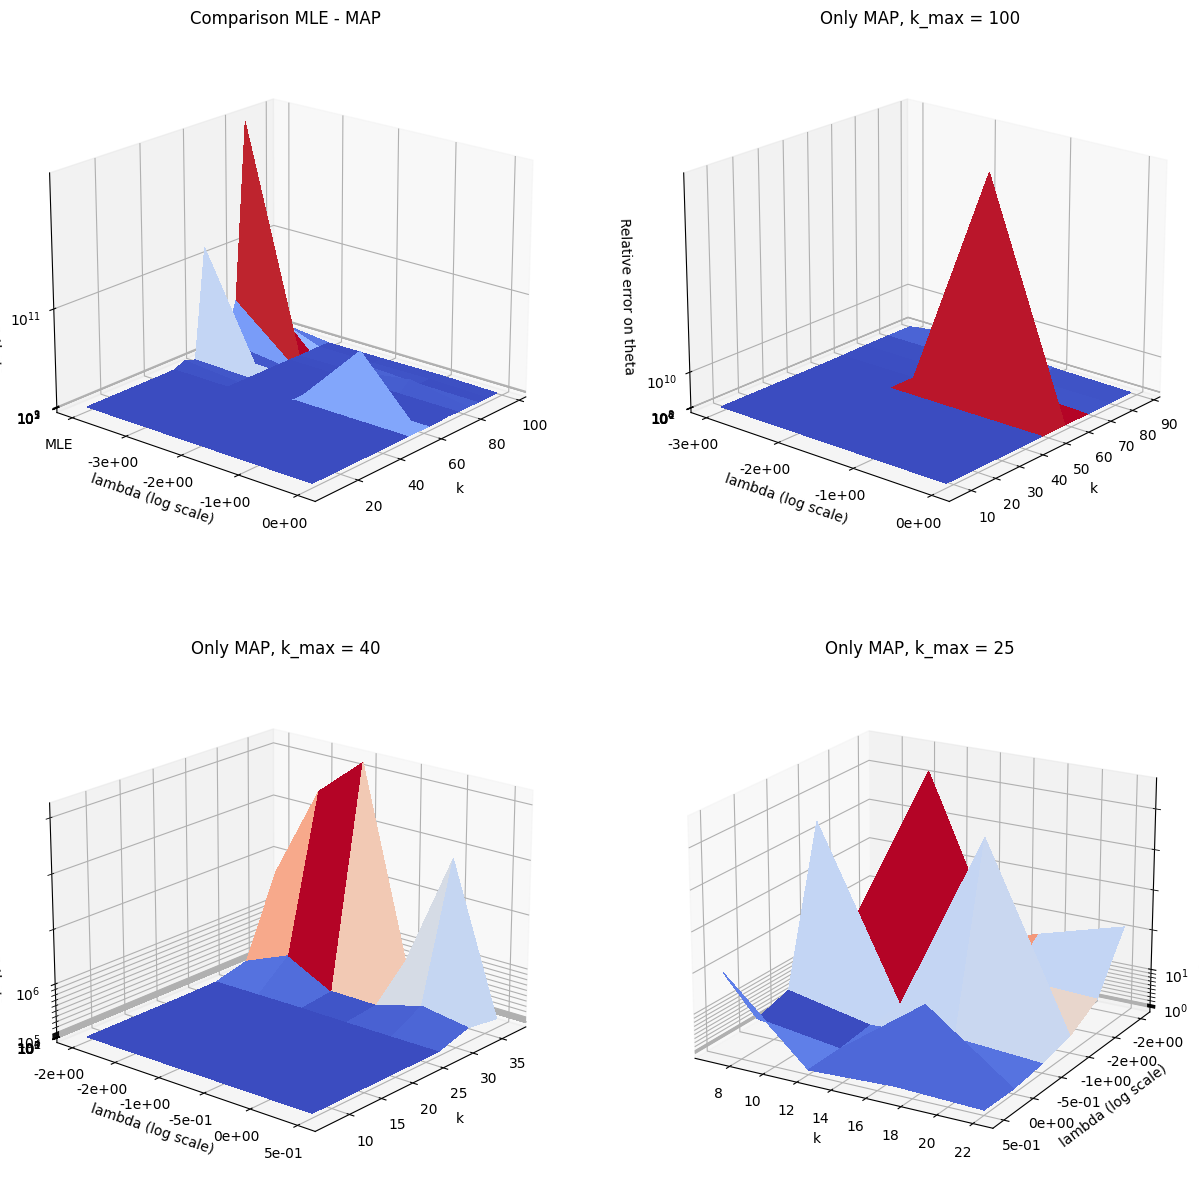

In [20]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(15, 15))
axs = axs.flatten()

k_vals      = np.arange(7, 100, 5)
lmbd_ticks = list(np.arange(-4, 1, 1))
lmbd_labels = ["MLE"]+["{:.0e}".format(x) for x in lmbd_ticks[1:]]
lmbd_vals = np.array([0]+list(np.power(10., lmbd_ticks[1:])))
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[0], title="Comparison MLE - MAP")

k_vals      = np.arange(7, 90, 10)
lmbd_ticks = list(np.arange(-3, 1, 1))
lmbd_labels = ["{:.0e}".format(x) for x in lmbd_ticks]
lmbd_vals = np.power(10., lmbd_ticks)
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[1], title="Only MAP, k_max = 100")

k_vals      = np.arange(7, 40, 5)
lmbd_ticks = list(np.arange(-2, 1, 0.5))
lmbd_labels = ["{:.0e}".format(x) for x in lmbd_ticks]
lmbd_vals = np.power(10., lmbd_ticks)
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[2], title="Only MAP, k_max = 40")


k_vals      = np.arange(7, 25, 5)
lmbd_ticks = list(np.arange(-2, 1, 0.5))
lmbd_labels = ["{:.0e}".format(x) for x in lmbd_ticks]
lmbd_vals = np.power(10., lmbd_ticks)
plot_3d(k_vals, lmbd_ticks, lmbd_labels, lmbd_vals, axs[3], rotation=120, title="Only MAP, k_max = 25")


We can see here that the regularization effect is much weaker with respect to the one on the last exercise.

In [21]:
def get_data_to_start_optimization(K, a, b, N_train):
    theta_true = np.ones(K)
    X_train = np.linspace(a, b, N_train)
    Y_train = get_y_from_x(X_train, K, theta_true)
    return X_train, Y_train

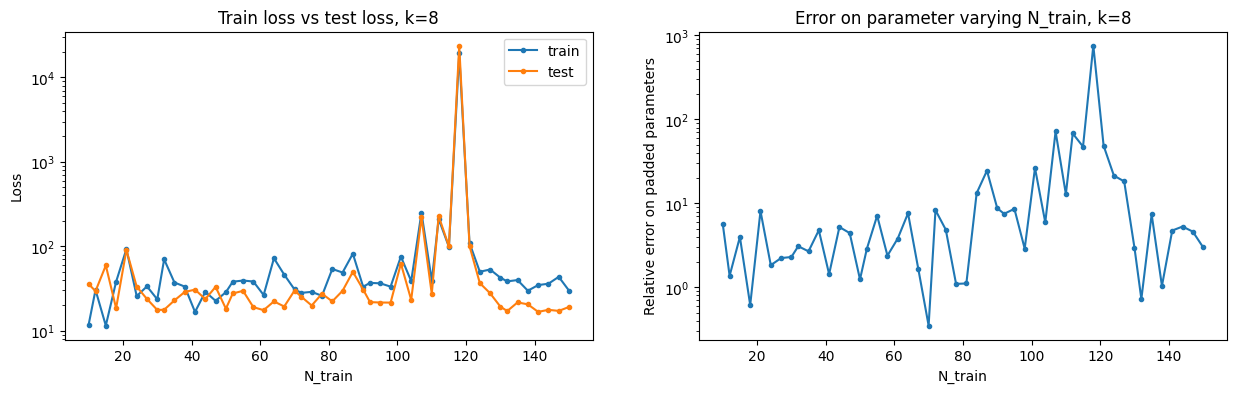

In [22]:
k = 8
lmbd = 5e-1
N_test = 30

train_accuracy = []
test_accuracy = []
param_error = []

theta_true = np.ones(k)
X_test = np.random.uniform(a, b, N_test)
Y_test = get_y_from_x(X_test, k, theta_true)


for N_train in (N_vals:=np.linspace(10, 150, dtype=np.int64)):
    X_train, Y_train = get_data_to_start_optimization(k, a, b, N_train)

    vander_train = get_normal_vandermonde(k, X_train)
    theta_MLE = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=lmbd)
    train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

    vander_test = get_normal_vandermonde(k, X_test)
    test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

    resized_th_true = np.pad(theta_true, (0, k-len(theta_true)))
    param_error.append(np.linalg.norm(resized_th_true - theta_MLE) / np.linalg.norm(resized_th_true))

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs = axs.flatten()

axs[0].plot(N_vals, train_accuracy, marker=".", label="train")
axs[0].plot(N_vals, test_accuracy, marker=".", label="test")
axs[0].set_title("Train loss vs test loss, k=8")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("N_train")
axs[0].set_yscale("log")
axs[0].legend()


axs[1].plot(N_vals, param_error, marker=".")
axs[1].set_title("Error on parameter varying N_train, k=8")
axs[1].set_ylabel("Relative error on padded parameters")
axs[1].set_xlabel("N_train")
axs[1].set_yscale("log")

plt.show()

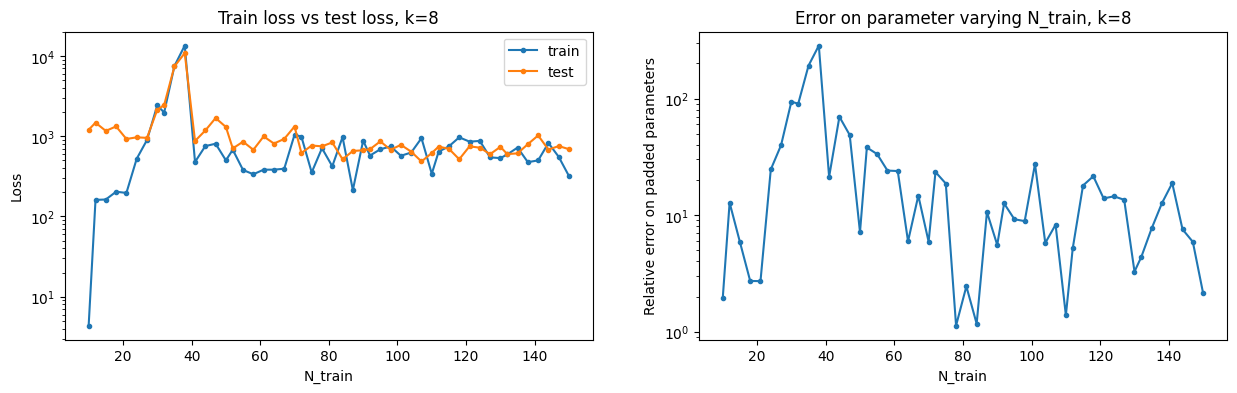

In [23]:
k = 13
lmbd = 5e-1
N_test = 30

train_accuracy = []
test_accuracy = []
param_error = []

theta_true = np.ones(k)
X_test = np.random.uniform(a, b, N_test)
Y_test = get_y_from_x(X_test, k, theta_true)


for N_train in (N_vals:=np.linspace(10, 150, dtype=np.int64)):
    X_train, Y_train = get_data_to_start_optimization(k, a, b, N_train)

    vander_train = get_normal_vandermonde(k, X_train)
    theta_MLE = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=lmbd)
    train_accuracy.append(loss(vander_train, Y_train, theta_MLE))

    vander_test = get_normal_vandermonde(k, X_test)
    test_accuracy.append(loss(vander_test, Y_test, theta_MLE))

    resized_th_true = np.pad(theta_true, (0, k-len(theta_true)))
    param_error.append(np.linalg.norm(resized_th_true - theta_MLE) / np.linalg.norm(resized_th_true))

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs = axs.flatten()

axs[0].plot(N_vals, train_accuracy, marker=".", label="train")
axs[0].plot(N_vals, test_accuracy, marker=".", label="test")
axs[0].set_title("Train loss vs test loss, k=8")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("N_train")
axs[0].set_yscale("log")
axs[0].legend()


axs[1].plot(N_vals, param_error, marker=".")
axs[1].set_title("Error on parameter varying N_train, k=8")
axs[1].set_ylabel("Relative error on padded parameters")
axs[1].set_xlabel("N_train")
axs[1].set_yscale("log")

plt.show()

Also for the poisson distribution the bigger number of data implies a better generalization, reducing the gap between train and test loss

In [24]:
def loss_func(theta, X, Y, vander):
    N = len(Y)
    vander = get_normal_vandermonde(k, X)
    tmp = (vander @ theta) - Y
    return (tmp.T @ tmp)/N

def grad_func(theta, X, Y, k):
    N = len(Y)
    vander = get_normal_vandermonde(k, X)
    return vander.T @ (vander @ theta - Y)/N

In [25]:
def is_fininshed(grad_f, wk, wk_1, w0, X, Y, k, tolf, tolx):
    vander = get_normal_vandermonde(k, X)

    flag_rel = np.linalg.norm(grad_f(wk, X, Y, k))**2 < (tolf * np.linalg.norm(grad_f(w0, X, Y, k))**2)
    flag_abs = np.linalg.norm(wk-wk_1)**2 < tolx
    return flag_rel and flag_abs


def SGD(loss_func, grad_func, k, w0, data, batch_size, n_epochs):
    '''
    Applies SGD on a logistic regressor with MSE loss
    If batch_size is set to -1, we configure it as normal GD with stopping conditions
    '''
    alpha = 1e-6

    X, Y = data

    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []

    ### only useful for GD
    tolx = 1e-6
    tolf = 1e-6
    # set up for normal GD
    if batch_size == -1:
        batch_size = len(Y)
        n_epochs = 100
    ###

    for epoch in range(n_epochs):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[indeces]
        Y = Y[indeces]

        for i in range(0, len(Y), batch_size):
            batch_X = X[i:i+batch_size]
            batch_Y = Y[i:i+batch_size]

            new_weights = w[-1] - alpha*grad_func(w[-1], batch_X, batch_Y, k)

            w.append(new_weights)

        loss_val.append(loss_func(w[-1], X, Y, k))
        grads_val.append(grad_func(w[-1], X, Y, k))
        err_val.append(np.linalg.norm(grads_val[-1])**2)

        # GD convergence check
        if batch_size == len(Y):
            if is_fininshed(grad_func, w[-1], w[-2], w[0], X, Y, k, tolf, tolx):
                break
    
    return w, loss_val, grads_val, err_val

In [26]:
def get_comparison_MLE_MAP_GD_SGD(k):
    lmbd = 1e-1
    N_train = 100
    N_test = 30

    theta_true = np.ones(k)
    X_test = np.random.uniform(a, b, N_test)
    Y_test = get_y_from_x(X_test, k, theta_true)
    X_train, Y_train = get_data_to_start_optimization(k, a, b, N_train)

    vander_train = get_normal_vandermonde(k, X_train)
    w_GD, loss_val, grads_val, err_val = SGD(loss_func, grad_func, k, np.zeros(k), (X_train, Y_train), -1, 500)
    w_SGD, loss_val, grads_val, err_val = SGD(loss_func, grad_func, k, np.zeros(k), (X_train, Y_train), 32, 20)

    theta_MLE = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=0)
    theta_MAP = MAP_normal_equations(vander = vander_train, Y = Y_train, lmbd=lmbd)
    theta_GD = w_GD[-1]
    theta_SGD = w_SGD[-1]

    resized_th_true = np.pad(theta_true, (0, k-len(theta_true)))

    errors = [np.linalg.norm(resized_th_true - th) / np.linalg.norm(resized_th_true) for th in [theta_MLE, theta_MAP, theta_GD, theta_SGD]]

    return errors

In [35]:
total_errors = []
for k in (k_vals:=np.arange(4, 13, 1)):
    total_errors.append(get_comparison_MLE_MAP_GD_SGD(int(k)))

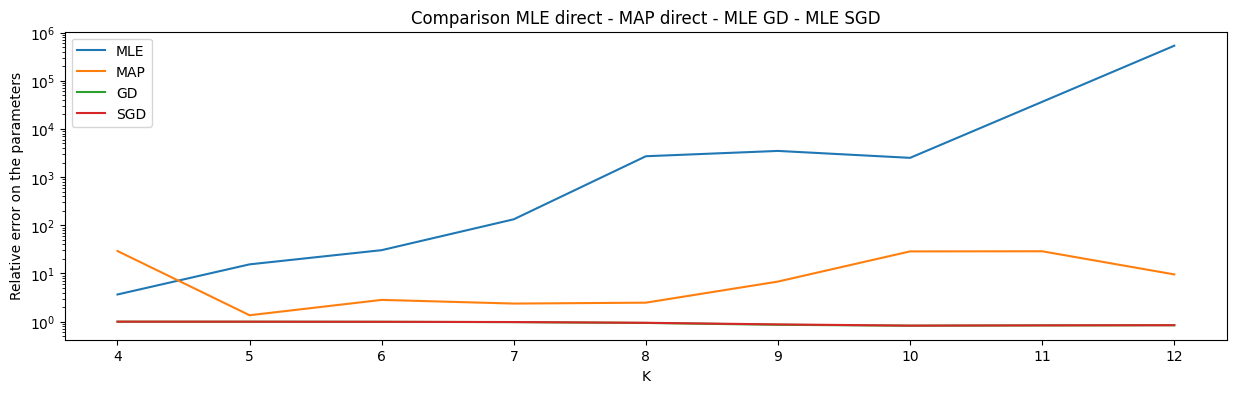

In [36]:
_, ax = plt.subplots(1, 1,figsize=(15, 4))
labels = ["MLE", "MAP", "GD", "SGD"]
for i in range(len(labels)):
    ax.plot(k_vals, [total_errors[j][i] for j in range(len(total_errors))], label=labels[i])

ax.legend()
ax.set_xlabel("K")
ax.set_ylabel("Relative error on the parameters")
ax.set_title("Comparison MLE direct - MAP direct - MLE GD - MLE SGD")
ax.set_yscale("log")
plt.show()

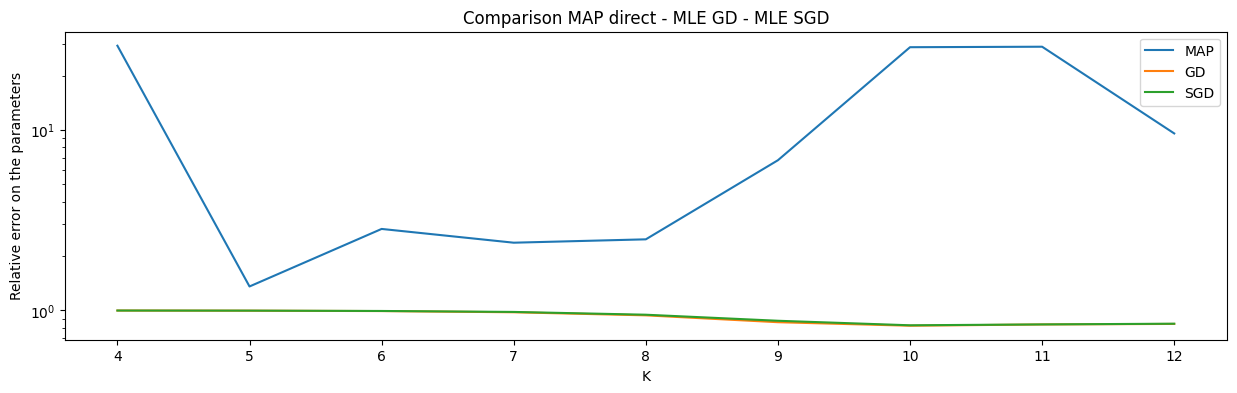

In [37]:
_, ax = plt.subplots(1, 1,figsize=(15, 4))
for i in range(1, len(labels)):
    ax.plot(k_vals, [total_errors[j][i] for j in range(len(total_errors))], label=labels[i])

ax.legend()
ax.set_xlabel("K")
ax.set_ylabel("Relative error on the parameters")
ax.set_title("Comparison MAP direct - MLE GD - MLE SGD")
ax.set_yscale("log")
plt.show()

Here we can see that gradient descent MLE can achieve much better results than using the normal equations

/tmp/ipykernel_5030/3405224788.py:5: RuntimeWarning: overflow encountered in matmul
  return (tmp.T @ tmp)/N
/tmp/ipykernel_5030/3405224788.py:10: RuntimeWarning: overflow encountered in matmul
  return vander.T @ (vander @ theta - Y)/N
/tmp/ipykernel_5030/1120935389.py:42: RuntimeWarning: invalid value encountered in subtract
  new_weights = w[-1] - alpha*grad_func(w[-1], batch_X, batch_Y, k)


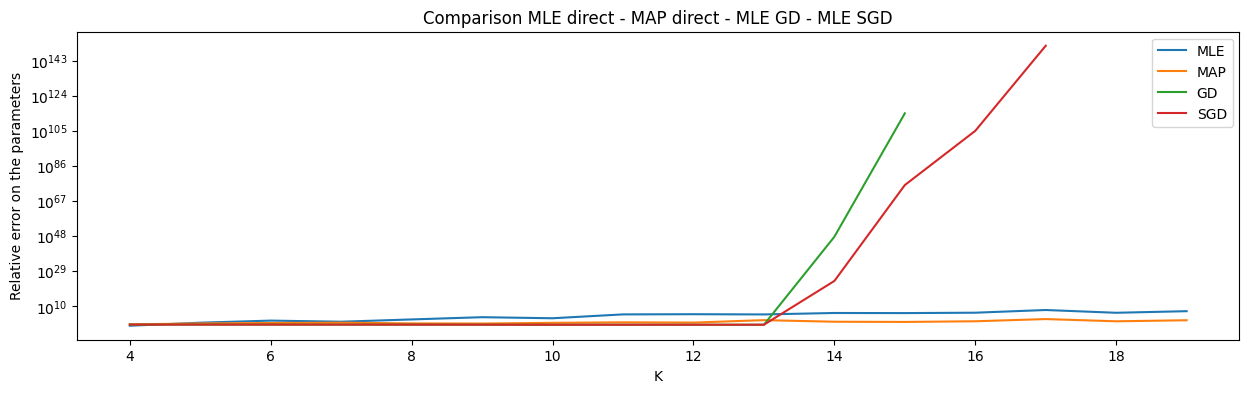

In [38]:
total_errors = []
for k in (k_vals:=np.arange(4, 20, 1)):
    total_errors.append(get_comparison_MLE_MAP_GD_SGD(int(k)))

_, ax = plt.subplots(1, 1,figsize=(15, 4))
labels = ["MLE", "MAP", "GD", "SGD"]
for i in range(len(labels)):
    ax.plot(k_vals, [total_errors[j][i] for j in range(len(total_errors))], label=labels[i])

ax.legend()
ax.set_xlabel("K")
ax.set_ylabel("Relative error on the parameters")
ax.set_title("Comparison MLE direct - MAP direct - MLE GD - MLE SGD")
ax.set_yscale("log")
plt.show()

But increasing the dimensionality of the regressor creates very big problems to gradient descent methods. This could be caused by the fact that the exponential trend of the poisson curve amplifies the difference $$\Phi(X) \theta - Y$$ and so the gradients increases magnitude very rapidly, causing divergence. We can also see that SGD fares a little bit better that normal full GD, probably because of the intrinsic regularization.